# MIS 583 Assignment 6: Text Sentiment Classification with Prompt Learning

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 游雅淇, B104020012

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive or negative based on the emotions customers express within them.

In Task 1, you need to fine-tune a pre-trained language model (e.g., BERT) to predict the sentiment of given tweets.

In Task 2, we employ prompts to enable the model to perform sentiment analysis through in-context learning, eliminating the need for additional training.

In Task 3, you will use the method called LM-BFF to utilize the model in generating the optimal template and verbalizer autonomously.


# Notice
**You are not allow to use the model like GPT family or pre-trained weight using SST-2 and twitter dataset!!!!!!!!!!!!!!!!!**

You can use BERT and RoBERTa encoder model

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.  
We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`.  
This is the default version in Google Colab.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
torch 2.1.0+cu121
torchvision 0.16.0+cu121


# Task 1: Text Sentiment Classification (40 points)

In this task, you need to fine-tune a pre-trained language model (e.g., BERT or RoBERTa encoder) to predict the sentiment of given tweets.


## Loading Model and Data

First, let's talk about the model. The Hugging Face team has created an amazing framework called "transformers" for NLP tasks. It includes many state-of-the-art machine learning models for PyTorch, TensorFlow, and JAX.

To start with this package, follow [this link to installation and a basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [ ]:
# you might need some additional installations there
!echo happy installation
!pip -V
!pip install grpcio
!pip install google-auth
!pip install protobuf==3.9.2
!pip install pyprind
!pip install tqdm boto3 requests regex sentencepiece sacremoses

happy installation
pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Using cached protobuf-3.9.2-py2.py3-none-any.whl (431 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.9.2 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.9.2 which is incompatible.
google-cloud-aiplatform 1.38.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev

In [ ]:
from torch import nn

#########################################################################
#            Loading tokenizer and model from transformer               #
#########################################################################
from transformers import BertTokenizerFast, BertForSequenceClassification

bert_type = 'bert-base-uncased'


# ---------- 1. load from torch.hub ----------
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', bert_type)

# create a Bert-extended task (classification)
model = torch.hub.load('huggingface/pytorch-transformers', 'model', bert_type)

# ---------- 2. load from installed huggingface ----------
tokenizer = BertTokenizerFast.from_pretrained(bert_type)

# create a Bert-extended task (classification)
model = BertForSequenceClassification.from_pretrained(bert_type)



# finetune from the output from bert to your task
model.classifier = nn.Linear(768, 3, bias=True)
#########################################################################
#                          End of your code                             #
#########################################################################

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `twitter_sentiment.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip Data

解壓縮 `twitter_sentiment.zip` 後可以發現裡面有三個csv檔。

- `train.csv`, `test.csv` and `val.csv`

Training set 有 **10248** 筆資料.  
Validation set 有 **1317** 筆資料.  
Testing set 有 **3075** 筆資料.  

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [ ]:
!unzip -qq ./drive/MyDrive/DeepLearning/A6/twitter_sentiment.zip

# Loading the dataset

In [ ]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []

    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path) as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [ ]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode

        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list

    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

## `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [ ]:
%cd /content/drive/MyDrive/DeepLearning/A6

/content/drive/MyDrive/DeepLearning/A6


In [ ]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1317 datas
mode test has 3075 datas


In [ ]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0]) # converts a sequence of numeric IDs in the training dataset into their corresponding tokens using the specified tokenizer.
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t)) # converts a sequence of tokens (t) back into the original text string using the specified tokenizer.

token ['[CLS]', '@', 'united', 'i', 'have', 'never', 'been', 'mis', '##lea', '##d', 'by', 'a', 'company', 'as', 'many', 'times', 'as', 'i', 'have', 'this', 'week', 'by', 'united', 'airlines', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
token to s [CLS] @ united i have never been mislead by a company as many times as i have this week by united airlines! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# Define loss and optimizer

In [ ]:
device = torch.device('cuda')

from torch import nn
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Utility Function

In [ ]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

# Train function

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Testing process                              #
        #########################################################################
        # 1. Clean the gradients of optimizer
        optimizer.zero_grad()
        # 2. Put correct variables into model
        outputs = model(text, mask)
        # 3. Get prediction
        # 4. Evalutate by criterion and accuracy
        loss = criterion(outputs.logits, label)
        acc = accuracy(outputs.logits, label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Training process                             #
        #########################################################################
        # 1. Put correct variables into model
        with torch.no_grad():
            outputs = model(text, mask)
        # 2. Get prediction
        # 3. Evalutate by criterion and accuracy
        loss = criterion(outputs.logits, label)
        acc = accuracy(outputs.logits, label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)

    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

# Start Training

In [ ]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 10
log_interval = 1
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)

    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))

    m.update(train_loss, train_acc, val_loss, val_acc)

    # model checkpoint
    torch.save(model.state_dict(), 'ckpts/e{}.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

100%|██████████| 42/42 [00:04<00:00,  8.87it/s]


Epoch 1 train_loss: 0.010577772350677934 train_acc: 0.711943793911007
Epoch 1 val_loss:  0.013841058597839866 val_acc : 0.8420652999240699
---------- e 1 save best model ----------


100%|██████████| 42/42 [00:04<00:00,  8.81it/s]


Epoch 2 train_loss: 0.00592626416059698 train_acc: 0.8537275565964091
Epoch 2 val_loss:  0.013291807351640978 val_acc : 0.8428246013667426
---------- e 2 save best model ----------


100%|██████████| 42/42 [00:04<00:00,  8.77it/s]


Epoch 3 train_loss: 0.004228772981576534 train_acc: 0.9045667447306791
Epoch 3 val_loss:  0.014311166637171916 val_acc : 0.8375094912680334


100%|██████████| 42/42 [00:04<00:00,  8.81it/s]


Epoch 4 train_loss: 0.0028719041946545466 train_acc: 0.9381342701014832
Epoch 4 val_loss:  0.016361935323722314 val_acc : 0.8344722854973424


100%|██████████| 42/42 [00:04<00:00,  8.77it/s]


Epoch 5 train_loss: 0.0017717421103187435 train_acc: 0.9648711943793911
Epoch 5 val_loss:  0.018173150620624797 val_acc : 0.8367501898253606


100%|██████████| 42/42 [00:04<00:00,  8.80it/s]


Epoch 6 train_loss: 0.0013377987901454066 train_acc: 0.975312256049961
Epoch 6 val_loss:  0.018626492740370718 val_acc : 0.8420652999240699


100%|██████████| 42/42 [00:04<00:00,  8.77it/s]


Epoch 7 train_loss: 0.000942068383092923 train_acc: 0.9829234972677595
Epoch 7 val_loss:  0.021132753558927863 val_acc : 0.8283978739559605


100%|██████████| 42/42 [00:04<00:00,  8.76it/s]


Epoch 8 train_loss: 0.0007408085530173036 train_acc: 0.985655737704918
Epoch 8 val_loss:  0.022966990904536397 val_acc : 0.8215641609719059


100%|██████████| 42/42 [00:04<00:00,  8.83it/s]


Epoch 9 train_loss: 0.0006389422344453168 train_acc: 0.9879976580796253
Epoch 9 val_loss:  0.023365410036082473 val_acc : 0.8306757782839788


100%|██████████| 42/42 [00:04<00:00,  8.75it/s]


Epoch 10 train_loss: 0.0005801083136047836 train_acc: 0.9882903981264637
Epoch 10 val_loss:  0.023423517845797683 val_acc : 0.8367501898253606


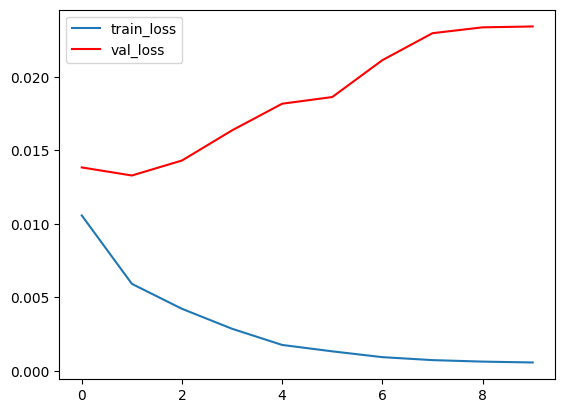

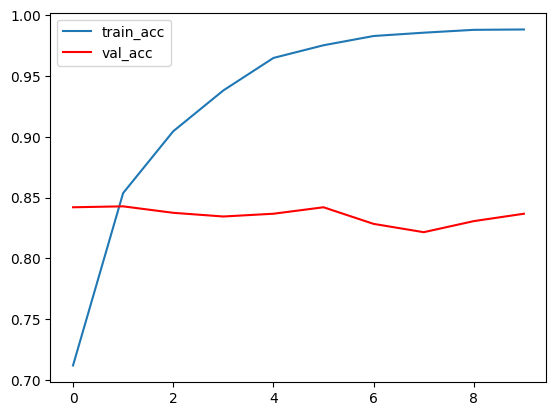

In [ ]:
# plot them out
m.plot()

# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/f072e95f51bc48978225941dba218241).


In [ ]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 97/97 [00:09<00:00,  9.88it/s]


# Task 2: In-Context learning (32 points)

In this task, you will learn how to perform sentiment classification using **prompts** without the need for training.

In [ ]:
import torch
import pyprind
import numpy as np
import pandas as pd
import torch.nn as nn
from transformers import BertConfig, BertTokenizer, BertForMaskedLM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loading model and setup

In [ ]:
#########################################################################
#         TODO: Design your own template(prefix) and verbalizer         #
#########################################################################
class Config:
    def __init__(self):

         # self.prefix = "This emotion sentence is [MASK]."# you can modify this line
        # self.prefix = (
        #     "Classify sentiment: It was a negative emotion sentence. @united never fails, flying FC order ravioli get chicken. Tell the FA she says you should of told me, other people wanted chicken..idiot."
        #     "Classify sentiment: It was a positive emotion sentence. @AmericanAir SFO. Natt (the agent who helped me) really did an awesome job. "
        #     "Classify sentiment: It was a neurtal emotion sentence. @SouthwestAir for my travel I see bz class and get away are sld out. Anytime is available . How do I know how many anytime are available?"
        #     "Classify sentiment: It was a [MASK] emotion sententce."
        # )
        self.prefix = "The emotion sentence is classify to [MASK]."
        self.verbalizer = {
            'Positive': 2,
            'Neurtal': 1,
            'Negative': 0
        }

        self.max_seq_length = 512
        self.batch_size = 64


config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_type = 'bert-base-uncased'

model = BertForMaskedLM.from_pretrained(bert_type, num_labels = 3)

tokenizer = BertTokenizer.from_pretrained(bert_type)

bert_config = BertConfig.from_pretrained(bert_type)

bert = model.from_pretrained(bert_type, config=bert_config).to(device)

#######################################################################
#                        End of your code                             #
#######################################################################

softmax = nn.Softmax(dim=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

## Obtaion verbalizer ids

In [ ]:
# Utility function to obtaion verbalizer ids
def obtain_verbalizer_ids(verbalizer, tokenizer):
    verbalizer_ids = tokenizer.convert_tokens_to_ids(list(verbalizer.keys()))
    index2ids = {i: verbalizer_ids[i] for i in range(len(verbalizer_ids))}
    return verbalizer_ids, index2ids


In [ ]:
verbalizer_ids, index2ids = obtain_verbalizer_ids(config.verbalizer, tokenizer)

## Concatenate original text and prefix

In [ ]:
# Utility function to concatenate prefix and text
def concatenate_prefix(texts, config):
    ##################################################
    #   TODO: concatenate your own prefix and text   #
    ##################################################
    prefix_texts = []
    prefix_texts = [f"{config.prefix} {text}." for text in texts]
    ##################################################
    #                 End of your code               #
    ##################################################
    return prefix_texts

In [ ]:
%cd ./drive/MyDrive/DeepLearning/A6

[Errno 2] No such file or directory: './drive/MyDrive/DeepLearning/A6'
/content/drive/MyDrive/DeepLearning/A6


In [ ]:
def load_data(config):
    # ['texts', 'labels']
    df = pd.read_csv('./twitter_sentiment/train.csv')
    original_texts = df['text'].tolist()
    labels = df['sentiment_label'].tolist()

    texts = concatenate_prefix(original_texts, config)

    return texts, labels


texts, labels = load_data(config)

In [ ]:
# Batching of texts and labels for training or processing in batches
def pack_batch(texts, labels, batch_size):
    """
    :param texts: list
    :param labels: list
    :param batch_size: int
    :return batch_X: list
            [[text11, text12, ...], [text21, text22, ...], ...]
    :return batch_y: list
            [[label11, label12, ...], [label21, label22, ...], ...]
    :return batch_count: int
    """
    assert len(texts) == len(labels)

    if len(texts) % batch_size != 0:
        flag = False
        batch_count = int(len(texts) / batch_size) + 1
    else:
        flag = True
        batch_count = int(len(texts) / batch_size)

    batch_X, batch_y = [], []

    if flag:
        for i in range(batch_count):
            batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
            batch_y.append(labels[i * batch_size: (i + 1) * batch_size])
    else:
        for i in range(batch_count):
            if i == batch_count - 1:
                batch_X.append(texts[i * batch_size:])
                batch_y.append(labels[i * batch_size:])
            else:
                batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
                batch_y.append(labels[i * batch_size: (i + 1) * batch_size])

    return batch_X, batch_y, batch_count

In [ ]:
batch_X, batch_y, batch_count = pack_batch(texts, labels, config.batch_size)

## Inferencing the model without training

In [ ]:
with torch.no_grad():
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    pper = pyprind.ProgPercent(batch_count)
    for i in range(batch_count):
        inputs = batch_X[i]
        labels = batch_y[i]

        # Using the BERT tokenizer (tokenizer.batch_encode_plus), adding special tokens, ensuring a maximum sequence length, and handling padding/truncation
        tokens = tokenizer.batch_encode_plus(inputs, add_special_tokens=True,
                                             max_length=config.max_seq_length,
                                             padding='max_length', truncation=True)

        ids = torch.tensor(tokens['input_ids']).to(device)
        attention_mask = torch.tensor(tokens['attention_mask']).to(device)

        # Shape: (batch_size, max_seq_length, vocab_size)
        logits = bert(ids, attention_mask=attention_mask).logits

        mask_token_index = (ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        # Find [MASK] logits
        # shape: (batch_size, vocab_size)
        masked_logits = logits[mask_token_index[0], mask_token_index[1], :]

        # Extract the logits of the word in the verbalizer at the [MASK] position
        # shape: (batch_size, verbalizer_size)
        verbalizer_logits = masked_logits[:, verbalizer_ids]

        # Construct a pseudo-distribution from the logits in these verbalizers
        pseudo_distribution = softmax(verbalizer_logits)

        #################################################################################
        #   1. Find the index with the maximum probability in the pseudo-distribution   #
        #   2. Convert the index to the corresponding word ID                           #
        #   3. Convert the ID to a token                                                #
        #   4. Find the label corresponding to the token                                #
        #################################################################################

        pred_indices = torch.argmax(pseudo_distribution, dim=1).cpu().numpy()

        pred_ids = [verbalizer_ids[index] for index in pred_indices]

        pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)

        pred_labels = [config.verbalizer[token] if token in config.verbalizer else -1 for token in pred_tokens]

        #################################################################################
        #                             End of your code                                  #
        #################################################################################

        predict_all = np.append(predict_all, pred_labels)
        labels_all = np.append(labels_all, labels)

        pper.update()

    acc = accuracy_score(labels_all, predict_all)
    p = precision_score(labels_all, predict_all, average="weighted")
    r = recall_score(labels_all, predict_all, average="weighted")
    f1 = f1_score(labels_all, predict_all, average="weighted")

    print('accuracy: %f | precision: %f | recall: %f | f1: %f' % (acc, p, r, f1))

[ 97 %] Time elapsed: 00:06:53 | ETA: 00:00:10

# Task 3: LM-BFF (45 points)

https://arxiv.org/pdf/2012.15723.pdf

Unlike the previous task, LM-BFF can generate templates and verbalizers automatically.

# Get Data

請先到共用雲端硬碟將檔案 `SST-2.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/14MDYFasXU94dUE9DjgfcZE61iTRI2007/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

# Install openprompt

This library provides a standard, flexible and extensible framework to deploy the prompt-learning pipeline.

[OpenPrompt Documentation](https://thunlp.github.io/OpenPrompt/)

In [ ]:
!pip install openprompt

  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.9.2
    Uninstalling protobuf-3.9.2:
      Successfully uninstalled protobuf-3.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.25.1 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.1 which is incompatible.


# Import openprompt package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


# Setup cuda and whether to perform automatic generation

In [ ]:
cuda = True
auto_t = False # Whether to perform automatic template generation
auto_v = True # Whether to perform automatic verbalizer generation

# Load dataset and model

In [ ]:
!unzip -qq /content/drive/MyDrive/DeepLearning/A6/SST-2.zip

In [ ]:
%cd /content/drive/MyDrive/DeepLearning/A6

/content/drive/MyDrive/DeepLearning/A6


In [ ]:
from openprompt.data_utils.text_classification_dataset import SST2Processor
dataset = {}
dataset['train'] = SST2Processor().get_train_examples("./SST-2/")
dataset['validation'] = SST2Processor().get_dev_examples("./SST-2/")
dataset['test'] = SST2Processor().get_test_examples("./SST-2/")

In [ ]:
#print('load model...')
from openprompt.plms import load_plm

# load mlm model for main tasks
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "roberta-large")

# load generation model for template generation
template_generate_model, template_generate_tokenizer, template_generate_model_config, template_tokenizer_wrapper = load_plm('t5', 't5-large')

from openprompt.prompts import ManualVerbalizer, ManualTemplate

# if you wish to do automatic label word generation, the verbalizer is not the final verbalizer, and is only used for template generation.
verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']]) # Manually generate the verbalizer


###################################################################################################################
#   TODO: You need to switch LMBFFTemplateGenerationTemplate or ManualTemplate to                                 #
#         compare auto generate template and manual generate template                                             #
###################################################################################################################
from openprompt.prompts.prompt_generator import LMBFFTemplateGenerationTemplate

############################################
#   LMBFFTemplateGenerationTemplate        #
############################################
import random

# number of demonstrations
if auto_t:
    num_demonstrations = 1  # try different number

    demonstrations = []


    for _ in range(num_demonstrations):
        # random choice training set example with label 0
        random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

        # random choice training set example with label 1
        random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])

        demonstration = f'{random_example_1.text_a} It was awful. {random_example_2.text_a} It was awesome.'
        demonstrations.append(demonstration)

    # You can modify the demonstrations and try different combinations
    template_text = '{"placeholder": "text_a"} {"mask"} {"meta": "labelword"} {"mask"}.' + ' '.join(demonstrations)
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)

#############################################
#   End of LMBFFTemplateGenerationTemplate  #
#############################################

########################################
#          ManualTemplate              #
########################################
else:
  num_demonstrations = 1
  demonstrations = []

  for _ in range(num_demonstrations):
      # random choice training set example with label 0
      random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

      # random choice training set example with label 1
      random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])

      demonstration = f'{random_example_1.text_a} Classify sentiment: This is awesome.  {random_example_2.text_a} Classify sentiment: This is awful.'
      demonstrations.append(demonstration)

  # Template 1: It was terrible / great (try to change it back to easier version )
  # Template 2: The tweet tells the {"mask"} sentiment. -> 0.48 (awful QQ)
  # Template 3: Classify the sentiment of the message: It is a {"mask"}
  # Template 4: Classify sentiment: It was {"mask"}
  # Awful - Awesome
  template_text = '{"placeholder":"text_a"}  Classify sentiment:  {"mask"} .' + ' '.join(demonstrations)
  template = ManualTemplate(tokenizer=tokenizer, text=template_text)
  verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['aweful'],['awesome']])

########################################
#          End of ManualTemplate       #
########################################

###################################################################################################################
#                                           End of your code                                                      #
###################################################################################################################


# view wrapped example
wrapped_example = template.wrap_one_example(dataset['train'][0])
print("dataset:", dataset['train'][0])


# Utility Function

In [ ]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

# Returns the best evaluation score achieved during training
def fit(model, train_dataloader, val_dataloader, loss_func, optimizer):
    best_score = 0.0
    for epoch in range(5):
        train_loss = train_epoch(model, train_dataloader, loss_func, optimizer)
        score = evaluate(model, val_dataloader)
        if score > best_score:
            best_score = score
        print(f"Epoch {epoch+1}: Train loss={train_loss}, Eval score={score}")
    return best_score

# Trains the model on the training data and computes the training loss
def train_epoch(model, train_dataloader, loss_func, optimizer):
    model.train()
    loss_all = []
    for step, inputs in enumerate(train_dataloader):
        if cuda:
            inputs = inputs.cuda()
        #####################################################
        # 1. Put correct variables into model to get logits #
        # 2. Get labels                                     #
        # 3. Evalutate using loss_func                         #
        # 4. Append loss to loss_all                        #
        #####################################################
        logits = model(batch=inputs)
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        loss_all.append(loss.item())
        #####################################################
        #                 End of your code                  #
        #####################################################
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(loss_all)

def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if cuda:
                inputs = inputs.cuda()
            #####################################################
            # 1. Put correct variables into model to get logits #
            # 2. Get labels                                     #
            # 3. Extend labels to list                          #
            # 4. Get predictions and extend preds to list        #
            #####################################################
            logits = model(batch=inputs)
            labels = inputs['label']
            alllabels.extend(labels.cpu().numpy())
            allpreds.extend(logits.argmax(dim=1).cpu().numpy())
            #####################################################
            #                 End of your code                  #
            #####################################################
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

# Automatic template generation

Generated template from TemplateGenerator and find the best template

In [ ]:
from tqdm import tqdm

class ManualTemplateWithoutParse(ManualTemplate):
    """The generated template from TemplateGenerator is a list of dict of parsed template_text. So no further parsing is needed."""
    def on_text_set(self):
        pass

# Template generation
if auto_t:
    print('performing auto_t...')

    if cuda:
        template_generate_model = template_generate_model.cuda()

    # Creates an instance of T5TemplateGenerator, used for generating text templates
    template_generator = T5TemplateGenerator(template_generate_model, template_generate_tokenizer, template_tokenizer_wrapper, verbalizer, beam_width=5) # Beam_width is set to 5 here for efficiency; to improve performance, try a larger number.


    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=template_generate_tokenizer, tokenizer_wrapper_class=template_tokenizer_wrapper, batch_size=len(dataset['train']), decoder_max_length=128, max_seq_length=128, shuffle=False, teacher_forcing=False) # Register all data at once
    for data in dataloader:
        if cuda:
            data = data.cuda()
        template_generator._register_buffer(data)

    template_generate_model.eval()
    print('generating...')
    template_texts = template_generator._get_templates() # Calls _get_templates on template_generator to generate template texts.

    # Converting and Printing Templates
    original_template = template.text
    template_texts = [template_generator.convert_template(template_text, original_template) for template_text in template_texts]
    # template_generator._show_template()
    template_generator.release_memory()
    # Generate a number of candidate template text
    print(template_texts)

    # Iterate over each candidate and select the best one
    best_metrics = 0.0
    best_template_text = None
    for template_text in tqdm(template_texts):
        verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']])
        template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
        print(f"current template: {template_text}, wrapped example: {template.wrap_one_example(dataset['train'][0])}")

        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to Find your best template_text     #
        #######################################################
        if score > best_metrics :
            best_metrics = score
            best_template_text = template_text
        #######################################################
        #                 End of your code                    #
        #######################################################
    # Use the best template
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']])
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
    print("final best template:", best_template_text)
    print("wrapped example:", template.wrap_one_example(dataset["train"][0]))

performing auto_t...


tokenizing: 32it [00:00, 704.15it/s]


generating...


100%|██████████| 18/18 [00:54<00:00,  3.05s/it]


['{"placeholder": "text_a"} It was {"mask"} ..as lively an account as seinfeld is deadpan . It was awful. you \'re not merely watching history , you \'re engulfed by it . It was awesome.', '{"placeholder": "text_a"} it was {"mask"} ..as lively an account as seinfeld is deadpan . It was awful. you \'re not merely watching history , you \'re engulfed by it . It was awesome.', '{"placeholder": "text_a"} A {"mask"} film.as lively an account as seinfeld is deadpan . It was awful. you \'re not merely watching history , you \'re engulfed by it . It was awesome.', '{"placeholder": "text_a"} It was {"mask"} . It was great.as lively an account as seinfeld is deadpan . It was awful. you \'re not merely watching history , you \'re engulfed by it . It was awesome.', '{"placeholder": "text_a"} It was {"mask"} . it was great.as lively an account as seinfeld is deadpan . It was awful. you \'re not merely watching history , you \'re engulfed by it . It was awesome.']


  0%|          | 0/5 [00:00<?, ?it/s]

current template: {"placeholder": "text_a"} It was {"mask"} ..as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome., wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " ..as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 405.06it/s]

tokenizing: 32it [00:00, 471.43it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3788503396644956, Eval score=0.5
Epoch 2: Train loss=0.7209148601396009, Eval score=0.5
Epoch 3: Train loss=0.7038224078714848, Eval score=0.5625
Epoch 4: Train loss=0.7475416832273822, Eval score=0.5


 20%|██        | 1/5 [01:36<06:24, 96.03s/it]

Epoch 5: Train loss=0.9873891160823405, Eval score=0.59375
current template: {"placeholder": "text_a"} it was {"mask"} ..as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome., wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' it was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " ..as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 985.46it/s]

tokenizing: 32it [00:00, 891.76it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3662884222898128, Eval score=0.5
Epoch 2: Train loss=0.7605830564862117, Eval score=0.84375
Epoch 3: Train loss=0.2019781855542533, Eval score=0.71875
Epoch 4: Train loss=0.17794147432687168, Eval score=0.84375


 40%|████      | 2/5 [03:09<04:44, 94.69s/it]

Epoch 5: Train loss=0.41671413579206273, Eval score=0.5
current template: {"placeholder": "text_a"} A {"mask"} film.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome., wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' A', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " film.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 499.59it/s]

tokenizing: 32it [00:00, 554.56it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.0143360996180204, Eval score=0.75
Epoch 2: Train loss=0.5368834123923989, Eval score=0.71875
Epoch 3: Train loss=0.674017313940567, Eval score=0.8125
Epoch 4: Train loss=0.21578987682369188, Eval score=0.84375


 60%|██████    | 3/5 [04:43<03:08, 94.16s/it]

Epoch 5: Train loss=0.012904993138363352, Eval score=0.875
current template: {"placeholder": "text_a"} It was {"mask"} . It was great.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome., wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . It was great.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 891.61it/s]

tokenizing: 32it [00:00, 936.97it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.7561625321395695, Eval score=0.5
Epoch 2: Train loss=0.8468441884033382, Eval score=0.53125
Epoch 3: Train loss=1.0427600700058974, Eval score=0.5
Epoch 4: Train loss=0.7401762790977955, Eval score=0.53125


 80%|████████  | 4/5 [06:16<01:33, 93.72s/it]

Epoch 5: Train loss=0.7574067390523851, Eval score=0.875
current template: {"placeholder": "text_a"} It was {"mask"} . it was great.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome., wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . it was great.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 956.20it/s]

tokenizing: 32it [00:00, 976.92it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3558963533723727, Eval score=0.53125
Epoch 2: Train loss=0.5587274773133686, Eval score=0.9375
Epoch 3: Train loss=0.059063952230644645, Eval score=0.90625
Epoch 4: Train loss=0.0008127959414423458, Eval score=0.90625


100%|██████████| 5/5 [07:49<00:00, 93.92s/it]

Epoch 5: Train loss=0.00036845131387508445, Eval score=0.90625
final best template: {"placeholder": "text_a"} It was {"mask"} . it was great.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.
wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . it was great.as lively an account as seinfeld is deadpan . It was awful. you 're not merely watching history , you 're engulfed by it . It was awesome.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]


# Automatic verbalizer generation

Verbalizer template from VerbalizerGenerator and find the best verbalizer

In [ ]:
# Verbalizer generation
from openprompt.prompts.prompt_generator import RobertaVerbalizerGenerator
if auto_v:
    print('performing auto_v...')
    # Load generation model for verbalizer generation
    if cuda:
        plm = plm.cuda()

    # Creates an instance of RobertaVerbalizerGenerator, used for generating verbalizer.
    verbalizer_generator = RobertaVerbalizerGenerator(model=plm, tokenizer=tokenizer, candidate_num=20, label_word_num_per_class=20) # To improve performance, try larger numbers


    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, batch_size=32)
    for data in dataloader:
        if cuda:
            data = data.cuda()
        verbalizer_generator.register_buffer(data)

    # Calls generate on verbalizer_generator to generate label words.
    label_words_list = verbalizer_generator.generate()
    verbalizer_generator.release_memory()

    # Iterate over each candidate and select the best one
    current_verbalizer = copy.deepcopy(verbalizer)
    best_metrics = 0.0
    best_label_words = None
    for label_words in tqdm(label_words_list):
        current_verbalizer.label_words = label_words
        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, current_verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to find your best_label_word        #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_label_words = label_words
        #######################################################
        #                 End of your code                    #
        #######################################################
    # use the best verbalizer
    print("final best label words:", best_label_words)
    verbalizer = ManualVerbalizer(tokenizer, num_classes=2, label_words=best_label_words)

performing auto_v...


tokenizing: 32it [00:00, 256.32it/s]
  0%|          | 0/30 [00:00<?, ?it/s]
tokenizing: 32it [00:00, 568.82it/s]

tokenizing: 32it [00:00, 564.48it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.7308656173408963, Eval score=0.875
Epoch 2: Train loss=0.3342106766795041, Eval score=0.875
Epoch 3: Train loss=0.07138200757253799, Eval score=0.84375
Epoch 4: Train loss=0.1370800447516558, Eval score=0.84375


  3%|▎         | 1/30 [01:34<45:50, 94.86s/it]

Epoch 5: Train loss=0.39307233259023633, Eval score=0.65625



tokenizing: 32it [00:00, 571.40it/s]

tokenizing: 32it [00:00, 584.89it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.434628279064782, Eval score=0.875
Epoch 2: Train loss=0.3380645815486787, Eval score=0.84375
Epoch 3: Train loss=0.3330786572514626, Eval score=0.84375
Epoch 4: Train loss=0.02494255677356705, Eval score=0.875


  7%|▋         | 2/30 [03:08<43:54, 94.09s/it]

Epoch 5: Train loss=0.004318473111652565, Eval score=0.84375



tokenizing: 32it [00:00, 923.04it/s]

tokenizing: 32it [00:00, 914.32it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.8929610189502168, Eval score=0.625
Epoch 2: Train loss=0.9853983572684228, Eval score=0.5
Epoch 3: Train loss=0.867369195446372, Eval score=0.65625
Epoch 4: Train loss=0.4610640139968609, Eval score=0.875


 10%|█         | 3/30 [04:41<42:08, 93.65s/it]

Epoch 5: Train loss=0.7018242472789102, Eval score=0.5



tokenizing: 32it [00:00, 965.28it/s]

tokenizing: 32it [00:00, 879.83it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.6427864305256463, Eval score=0.5
Epoch 2: Train loss=0.5159604388172738, Eval score=0.8125
Epoch 3: Train loss=0.46437889635171814, Eval score=0.75
Epoch 4: Train loss=0.5576628510607406, Eval score=0.75


 13%|█▎        | 4/30 [06:14<40:26, 93.34s/it]

Epoch 5: Train loss=0.23769509304474923, Eval score=0.71875



tokenizing: 32it [00:00, 574.90it/s]

tokenizing: 32it [00:00, 627.25it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.7853019943868276, Eval score=0.59375
Epoch 2: Train loss=0.9519972576526925, Eval score=0.5
Epoch 3: Train loss=0.7045254241675138, Eval score=0.71875
Epoch 4: Train loss=0.6249904092401266, Eval score=0.78125


 17%|█▋        | 5/30 [07:47<38:49, 93.19s/it]

Epoch 5: Train loss=0.46443918682234653, Eval score=0.5625



tokenizing: 32it [00:00, 566.81it/s]

tokenizing: 32it [00:00, 586.65it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.072862896951847, Eval score=0.5625
Epoch 2: Train loss=0.47002663275634404, Eval score=0.78125
Epoch 3: Train loss=0.43007341233715124, Eval score=0.84375
Epoch 4: Train loss=0.22548287478639395, Eval score=0.875


 20%|██        | 6/30 [09:20<37:15, 93.14s/it]

Epoch 5: Train loss=0.02067576405931959, Eval score=0.78125



tokenizing: 32it [00:00, 613.33it/s]

tokenizing: 32it [00:00, 630.87it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.502819861532771, Eval score=0.84375
Epoch 2: Train loss=0.8812451722258743, Eval score=0.5
Epoch 3: Train loss=0.8604242359870113, Eval score=0.8125
Epoch 4: Train loss=0.3071428047842346, Eval score=0.84375


 23%|██▎       | 7/30 [10:53<35:42, 93.14s/it]

Epoch 5: Train loss=0.12942861425835872, Eval score=0.84375



tokenizing: 32it [00:00, 861.79it/s]

tokenizing: 32it [00:00, 914.16it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3163142184889125, Eval score=0.90625
Epoch 2: Train loss=0.43335610393842217, Eval score=0.875
Epoch 3: Train loss=0.3904178712373323, Eval score=0.84375
Epoch 4: Train loss=0.31130919674592405, Eval score=0.9375


 27%|██▋       | 8/30 [12:26<34:07, 93.06s/it]

Epoch 5: Train loss=0.015608099643031892, Eval score=0.875



tokenizing: 32it [00:00, 897.47it/s]

tokenizing: 32it [00:00, 973.60it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.268034351593087, Eval score=0.5
Epoch 2: Train loss=0.9597488800063729, Eval score=0.5
Epoch 3: Train loss=1.5211391863485915, Eval score=0.5
Epoch 4: Train loss=0.7215611223655287, Eval score=0.53125


 30%|███       | 9/30 [13:59<32:34, 93.06s/it]

Epoch 5: Train loss=0.30213573190849274, Eval score=0.75



tokenizing: 32it [00:00, 446.77it/s]

tokenizing: 32it [00:00, 449.36it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3375203337855055, Eval score=0.53125
Epoch 2: Train loss=0.778754698621924, Eval score=0.8125
Epoch 3: Train loss=0.3077308790321922, Eval score=0.8125
Epoch 4: Train loss=0.29794130604477687, Eval score=0.78125


 33%|███▎      | 10/30 [15:33<31:04, 93.21s/it]

Epoch 5: Train loss=0.3196651351731816, Eval score=0.71875



tokenizing: 32it [00:00, 958.45it/s]

tokenizing: 32it [00:00, 916.85it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.2653866897162516, Eval score=0.5
Epoch 2: Train loss=0.7281524856225587, Eval score=0.8125
Epoch 3: Train loss=0.14780651551973278, Eval score=0.78125
Epoch 4: Train loss=0.021847576900199783, Eval score=0.84375


 37%|███▋      | 11/30 [17:06<29:31, 93.22s/it]

Epoch 5: Train loss=0.008385709052454615, Eval score=0.8125



tokenizing: 32it [00:00, 1018.55it/s]

tokenizing: 32it [00:00, 1009.71it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.868155319375588, Eval score=0.5
Epoch 2: Train loss=0.9922446418786421, Eval score=0.625
Epoch 3: Train loss=0.525842147617368, Eval score=0.84375
Epoch 4: Train loss=0.2039537163254863, Eval score=0.8125


 40%|████      | 12/30 [18:39<27:59, 93.31s/it]

Epoch 5: Train loss=0.3620210453004802, Eval score=0.84375



tokenizing: 32it [00:00, 504.88it/s]

tokenizing: 32it [00:00, 621.61it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.032840773754282, Eval score=0.5
Epoch 2: Train loss=0.7120444811880589, Eval score=0.59375
Epoch 3: Train loss=0.6942830145962944, Eval score=0.90625
Epoch 4: Train loss=0.12957863551855553, Eval score=0.8125


 43%|████▎     | 13/30 [20:13<26:27, 93.36s/it]

Epoch 5: Train loss=0.010807514455791534, Eval score=0.8125



tokenizing: 32it [00:00, 987.74it/s]

tokenizing: 32it [00:00, 777.60it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.6624657374045455, Eval score=0.5
Epoch 2: Train loss=0.33922819351755606, Eval score=0.65625
Epoch 3: Train loss=0.48030682686101045, Eval score=0.5
Epoch 4: Train loss=0.26656636017287383, Eval score=0.84375


 47%|████▋     | 14/30 [21:46<24:52, 93.28s/it]

Epoch 5: Train loss=0.24192779287317023, Eval score=0.84375



tokenizing: 32it [00:00, 870.93it/s]

tokenizing: 32it [00:00, 879.52it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.5696520069035387, Eval score=0.5
Epoch 2: Train loss=1.2285213744617067, Eval score=0.5
Epoch 3: Train loss=0.563213175162673, Eval score=0.75
Epoch 4: Train loss=0.050665137837199836, Eval score=0.59375


 50%|█████     | 15/30 [23:19<23:19, 93.30s/it]

Epoch 5: Train loss=0.6302038946338087, Eval score=0.6875



tokenizing: 32it [00:00, 480.13it/s]

tokenizing: 32it [00:00, 564.61it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.4374728344751873, Eval score=0.5
Epoch 2: Train loss=1.5534925406973343, Eval score=0.4375
Epoch 3: Train loss=0.8014679537154734, Eval score=0.5
Epoch 4: Train loss=0.8582912464626133, Eval score=0.5


 53%|█████▎    | 16/30 [24:52<21:45, 93.25s/it]

Epoch 5: Train loss=0.7588534550741315, Eval score=0.5



tokenizing: 32it [00:00, 949.87it/s]

tokenizing: 32it [00:00, 1007.46it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.53555009447075, Eval score=0.5
Epoch 2: Train loss=1.001117654144764, Eval score=0.5
Epoch 3: Train loss=0.6860315389931202, Eval score=0.5
Epoch 4: Train loss=0.8017798159271479, Eval score=0.5


 57%|█████▋    | 17/30 [26:25<20:11, 93.18s/it]

Epoch 5: Train loss=0.7925674063153565, Eval score=0.5



tokenizing: 32it [00:00, 927.24it/s]

tokenizing: 32it [00:00, 920.64it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.2658059442183003, Eval score=0.875
Epoch 2: Train loss=0.4404232879751362, Eval score=0.75
Epoch 3: Train loss=0.37065357723622583, Eval score=0.84375
Epoch 4: Train loss=0.09877222162322141, Eval score=0.875


 60%|██████    | 18/30 [27:58<18:37, 93.10s/it]

Epoch 5: Train loss=0.2622024608645006, Eval score=0.875



tokenizing: 32it [00:00, 546.38it/s]

tokenizing: 32it [00:00, 544.94it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.8827171617885874, Eval score=0.5
Epoch 2: Train loss=0.9640453192405403, Eval score=0.53125
Epoch 3: Train loss=1.368772170163055, Eval score=0.5
Epoch 4: Train loss=0.8198381632100791, Eval score=0.5


 63%|██████▎   | 19/30 [29:32<17:04, 93.15s/it]

Epoch 5: Train loss=0.7447951924987137, Eval score=0.5



tokenizing: 32it [00:00, 905.67it/s]

tokenizing: 32it [00:00, 918.55it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.5852834931572202, Eval score=0.5
Epoch 2: Train loss=0.8073873344401363, Eval score=0.5
Epoch 3: Train loss=0.580040626344271, Eval score=0.75
Epoch 4: Train loss=0.20817268032897118, Eval score=0.59375


 67%|██████▋   | 20/30 [31:04<15:30, 93.08s/it]

Epoch 5: Train loss=0.036154895058757575, Eval score=0.6875



tokenizing: 32it [00:00, 547.06it/s]

tokenizing: 32it [00:00, 589.47it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.4807758441821761, Eval score=0.90625
Epoch 2: Train loss=0.8792197631846648, Eval score=0.625
Epoch 3: Train loss=0.3769124720201944, Eval score=0.9375
Epoch 4: Train loss=0.10601338281958306, Eval score=0.875


 70%|███████   | 21/30 [32:38<13:58, 93.16s/it]

Epoch 5: Train loss=0.0043554261301324, Eval score=0.90625



tokenizing: 32it [00:00, 928.22it/s]

tokenizing: 32it [00:00, 970.32it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.608389416300895, Eval score=0.90625
Epoch 2: Train loss=0.7901786317961523, Eval score=0.84375
Epoch 3: Train loss=0.28996773151447996, Eval score=0.84375
Epoch 4: Train loss=0.10132509288814617, Eval score=0.84375


 73%|███████▎  | 22/30 [34:11<12:24, 93.11s/it]

Epoch 5: Train loss=0.015030532123660123, Eval score=0.90625



tokenizing: 32it [00:00, 927.71it/s]

tokenizing: 32it [00:00, 931.76it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.494039619108662, Eval score=0.5
Epoch 2: Train loss=0.746291107032448, Eval score=0.5
Epoch 3: Train loss=0.5494736937798734, Eval score=0.84375
Epoch 4: Train loss=0.11936947945287102, Eval score=0.65625


 77%|███████▋  | 23/30 [35:44<10:51, 93.08s/it]

Epoch 5: Train loss=0.11575567502268314, Eval score=0.875



tokenizing: 32it [00:00, 557.88it/s]

tokenizing: 32it [00:00, 610.61it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.305606386391446, Eval score=0.5
Epoch 2: Train loss=0.7107183420739602, Eval score=0.8125
Epoch 3: Train loss=0.5290741748652863, Eval score=0.9375
Epoch 4: Train loss=0.07279806985570758, Eval score=0.875


 80%|████████  | 24/30 [37:17<09:18, 93.14s/it]

Epoch 5: Train loss=0.0045547049239367254, Eval score=0.875



tokenizing: 32it [00:00, 912.88it/s]

tokenizing: 32it [00:00, 998.01it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.427210847636161, Eval score=0.5
Epoch 2: Train loss=1.231894688331522, Eval score=0.5625
Epoch 3: Train loss=0.4895266574167181, Eval score=0.84375
Epoch 4: Train loss=0.2990022425284735, Eval score=0.84375


 83%|████████▎ | 25/30 [38:50<07:45, 93.14s/it]

Epoch 5: Train loss=0.5408657058236486, Eval score=0.8125



tokenizing: 32it [00:00, 511.98it/s]

tokenizing: 32it [00:00, 496.09it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.29197664960504, Eval score=0.53125
Epoch 2: Train loss=0.7762257028371096, Eval score=0.5625
Epoch 3: Train loss=0.5669488386483863, Eval score=0.5625
Epoch 4: Train loss=0.48617300303442335, Eval score=0.5


 87%|████████▋ | 26/30 [40:23<06:12, 93.18s/it]

Epoch 5: Train loss=0.18303347964011607, Eval score=0.59375



tokenizing: 32it [00:00, 1007.01it/s]

tokenizing: 32it [00:00, 928.00it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.975980084324874, Eval score=0.5
Epoch 2: Train loss=0.9030951374443248, Eval score=0.75
Epoch 3: Train loss=0.921239295596024, Eval score=0.53125
Epoch 4: Train loss=0.7739874662365764, Eval score=0.59375


 90%|█████████ | 27/30 [41:56<04:39, 93.12s/it]

Epoch 5: Train loss=0.6376506630331278, Eval score=0.78125



tokenizing: 32it [00:00, 801.64it/s]

tokenizing: 32it [00:00, 934.39it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.7670635919397064, Eval score=0.5
Epoch 2: Train loss=1.530751606231206, Eval score=0.5
Epoch 3: Train loss=0.9011580450460315, Eval score=0.5625
Epoch 4: Train loss=1.0613687403965741, Eval score=0.5


 93%|█████████▎| 28/30 [43:30<03:06, 93.20s/it]

Epoch 5: Train loss=1.0182906913687475, Eval score=0.5



tokenizing: 32it [00:00, 840.99it/s]

tokenizing: 32it [00:00, 924.93it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.300379943488224, Eval score=0.8125
Epoch 2: Train loss=0.627804022629789, Eval score=0.8125
Epoch 3: Train loss=0.3021319625520391, Eval score=0.90625
Epoch 4: Train loss=0.1488003215585536, Eval score=0.875


 97%|█████████▋| 29/30 [45:03<01:33, 93.19s/it]

Epoch 5: Train loss=0.01003011354185901, Eval score=0.875



tokenizing: 32it [00:00, 913.43it/s]

tokenizing: 32it [00:00, 918.33it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.10005693544565, Eval score=0.5
Epoch 2: Train loss=0.5232211776310578, Eval score=0.75
Epoch 3: Train loss=0.10024801531301364, Eval score=0.75
Epoch 4: Train loss=0.015656194909652754, Eval score=0.78125


100%|██████████| 30/30 [46:36<00:00, 93.23s/it]

Epoch 5: Train loss=0.0003926066138326689, Eval score=0.8125
final best label words: ['incredible', 'terrific']


# Evaluation

In [ ]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

tokenizing: 32it [00:00, 1000.05it/s]
tokenizing: 32it [00:00, 933.23it/s]
tokenizing: 872it [00:01, 512.81it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.0570310565526597, Eval score=0.9375
Epoch 2: Train loss=0.11199774296983378, Eval score=0.875
Epoch 3: Train loss=0.012060872409676904, Eval score=0.875
Epoch 4: Train loss=0.5678141137904049, Eval score=0.65625
Epoch 5: Train loss=0.5213084513770809, Eval score=0.75


# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/5b8876ed26fd495b8353ad7ce94b6f65).

In [ ]:
model.eval()

allpreds = []
for step, inputs in enumerate(test_dataloader):
    if cuda:
        inputs = inputs.cuda()
    logits = model(inputs)
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(allpreds):
        f.write('{},{}\n'.format(i, pred))

# Report (15 points)

- Task 1: Compare **two** different models you employed and provide a brief discussion of your implementation.

- Task 2: You need to try at least **three** different templates and verbalizers to compare how your prompts work with the model. Report your performance in zero-shot, one-shot, and few-shot scenarios, with examples drawn from the training set.

- Task 3: Try at least three different manually crafted templates to compare them with auto-generated templates. Evaluate the performance with different numbers of demonstrations and plot the graph from Figure 3 in the paper (https://arxiv.org/pdf/2012.15723.pdf). Also, report your best template and verbalizer.
